In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import cv2
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mmseg.registry import MODELS
from mmengine.config import Config
from mmengine.runner import Runner
from mmengine.model import BaseModule
from mmengine.registry import init_default_scope
init_default_scope('mmseg')
from mmseg.models.segmentors import EncoderDecoder
from mmseg.datasets.acdc import ACDCDataset
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.utils import save_image
import os
from torch.cuda import amp

/BS/DApt/work/build/conda/envs/seg2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_dataloader():
    dataloaders = []
    val_dataloaders = []
    #Fog
    dataset_config = '/BS/DApt/work/project/segformer_test/local_config/_base_/datasets/acdc_fog.py'
    cfg = Config.fromfile(dataset_config)
    dl1 = Runner.build_dataloader(cfg.train_dataloader)
    val_dl1 = Runner.build_dataloader(cfg.val_dataloader)
    dataloaders.append(dl1)
    val_dataloaders.append(val_dl1)
    #Night
    dataset_config = '/BS/DApt/work/project/segformer_test/local_config/_base_/datasets/acdc_night.py'
    cfg = Config.fromfile(dataset_config)
    dl2 = Runner.build_dataloader(cfg.train_dataloader)
    val_dl2 = Runner.build_dataloader(cfg.val_dataloader)
    dataloaders.append(dl2)
    val_dataloaders.append(val_dl2)
    #Rain
    dataset_config = '/BS/DApt/work/project/segformer_test/local_config/_base_/datasets/acdc_rain.py'
    cfg = Config.fromfile(dataset_config)
    dl3 = Runner.build_dataloader(cfg.train_dataloader)
    val_dl3 = Runner.build_dataloader(cfg.val_dataloader)
    dataloaders.append(dl3)
    val_dataloaders.append(val_dl3)
    #Snow
    dataset_config = '/BS/DApt/work/project/segformer_test/local_config/_base_/datasets/acdc_snow.py'
    cfg = Config.fromfile(dataset_config)
    dl4 = Runner.build_dataloader(cfg.train_dataloader)
    val_dl4 = Runner.build_dataloader(cfg.val_dataloader)
    dataloaders.append(dl4)
    val_dataloaders.append(val_dl4)

    return dataloaders,val_dataloaders

In [3]:
dataloaders,val_dataloaders = load_dataloader()

In [37]:
def convert_syncbn_to_bn(module):
    # reqd if training on 1 gpu
    mod = module
    if isinstance(module, nn.SyncBatchNorm):
        mod = nn.BatchNorm2d(module.num_features, module.eps, module.momentum, module.affine, module.track_running_stats)
        mod.running_mean = module.running_mean
        mod.running_var = module.running_var
        if module.affine:
            mod.weight = module.weight
            mod.bias = module.bias
    for name, child in module.named_children():
        mod.add_module(name, convert_syncbn_to_bn(child))
    return mod

def load_model():
    config_path = '/BS/DApt/work/project/segformer_test/local_config/my_models/b5_fog_IDASS.py'
    
    #pretrained = '/BS/DApt/work/project/segformer_test/work_dirs/oracle_gt_weigtedloss/fog_oraclev10_8x8_5/teacher.pth'  # weighted loss KL w/GT global
    pretrained = '/BS/DApt/work/project/segformer_test/work_dirs/fog_oraclev10_8x8_2.5/teacher.pth'
    
    

        
    cfg = Config.fromfile(config_path)
    print(cfg)
    encdec = EncoderDecoder(cfg.model.backbone, cfg.model.decode_head)
    weights = torch.load(pretrained)
  
    encdec.load_state_dict(weights)
    encdec = convert_syncbn_to_bn(encdec)

    encdec.cuda()
    encdec.requires_grad_(False) # Set requires_grad False
    
    for m in encdec.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.requires_grad_(True) # Grad true for norm layers
            
    return encdec

In [38]:

model = load_model()
model = model.cuda()

Config (path: /BS/DApt/work/project/segformer_test/local_config/my_models/b5_fog_IDASS.py): {'dataset_type': 'ACDCDataset', 'data_root': '/BS/DApt/work/project/segformer_test/acdc/ACDC/', 'crop_size': (960, 540), 'img_norm_cfg': {'mean': [123.675, 116.28, 103.53], 'std': [58.395, 57.12, 57.375], 'to_rgb': True}, 'train_pipeline': [{'type': 'LoadImageFromFile'}, {'type': 'LoadAnnotations'}, {'type': 'RandomResize', 'scale': (1920, 1080), 'ratio_range': (0.5, 2.0), 'keep_ratio': True}, {'type': 'RandomFlip', 'prob': 0.0}, {'type': 'RandomCrop', 'crop_size': (768, 768), 'cat_max_ratio': 0.75}, {'type': 'PackSegInputs'}], 'test_pipeline': [{'type': 'LoadImageFromFile'}, {'type': 'Resize', 'scale': (768, 768), 'keep_ratio': True}, {'type': 'LoadAnnotations'}, {'type': 'PackSegInputs'}], 'train_dataloader': {'batch_size': 2, 'num_workers': 4, 'persistent_workers': True, 'sampler': {'type': 'InfiniteSampler', 'shuffle': True}, 'dataset': {'type': 'ACDCDataset', 'data_root': '/BS/DApt/work/pro

In [25]:
# Cityscapes color palette
cityscapes_palette = {
    0:  (128, 64, 128),  # Road
    1:  (244, 35, 232),  # Sidewalk
    2:  (70, 70, 70),    # Building
    3:  (102, 102, 156), # Wall
    4:  (190, 153, 153), # Fence
    5:  (153, 153, 153), # Pole
    6:  (250, 170, 30),  # Traffic Light
    7:  (220, 220, 0),   # Traffic Sign
    8:  (107, 142, 35),  # Vegetation
    9:  (152, 251, 152), # Terrain
    10: (70, 130, 180),  # Sky
    11: (220, 20, 60),   # Person
    12: (255, 0, 0),     # Rider
    13: (0, 0, 142),     # Car
    14: (0, 0, 70),      # Truck
    15: (0, 60, 100),    # Bus
    16: (0, 80, 100),    # Train
    17: (0, 0, 230),     # Motorcycle
    18: (119, 11, 32),   # Bicycle
    255: (0, 0, 0)       # Masked (255)
}

def plot_preds(model, val_loader):
    val_loss = 0
    total_batches = len(val_loader)
    model.eval()

    # Define the class names corresponding to class IDs
    class_names = [
        'Road', 'Sidewalk', 'Building', 'Wall', 'Fence', 'Pole',
        'Traffic Light', 'Traffic Sign', 'Vegetation', 'Terrain',
        'Sky', 'Person', 'Rider', 'Car', 'Truck', 'Bus',
        'Train', 'Motorcycle', 'Bicycle'
    ]

    # Normalize the Cityscapes palette colors to [0, 1] range for matplotlib
    color_map = {k: np.array(v) / 255.0 for k, v in cityscapes_palette.items()}

    results = []
    for batch_ndx, sample in enumerate(val_loader):
        imgs = []
        for img in sample['inputs']:
            _, current_height, current_width = img.shape
            if img.dtype != torch.float32:
                img = img.float()
            rgb_image = img[[2, 1, 0], :, :]
            
            mean = torch.tensor([123.675, 116.28, 103.53]).view(3, 1, 1)
            std = torch.tensor([58.395, 57.12, 57.375]).view(3, 1, 1)

            # Normalize the image
            normalized_image = (rgb_image - mean) / std
            imgs.append(normalized_image)

        img = torch.stack(imgs, dim=0).cuda()
         
        batch_img_metas = [
            dict(
                ori_shape=img.shape[2:],
                img_shape=img.shape[2:],
                pad_shape=img.shape[2:],
                padding_size=[0, 0, 0, 0]
            )
        ] * img.shape[0]

        with torch.no_grad():
            logits = model.encode_decode(img, batch_img_metas)
            final_prediction = torch.softmax(logits, dim=1)
        
        gts = []
        for gt in sample['data_samples']:
            gt = gt._gt_sem_seg.data
            gt = gt.float()
            gts.append(gt)
        
        gt = torch.stack(gts, dim=0).cuda()

        # Resize ground truth to match the prediction size
        preds = final_prediction[1]
        gt_resized = F.interpolate(gt, size=preds.shape[1:], mode='nearest')
        
        gt_resized = gt_resized.squeeze(0).to(dtype=torch.int64).squeeze(1)
        break
    
    preds = final_prediction[1]
    pred_label = torch.argmax(preds, dim=0)

    pred_label_np = pred_label.cpu().numpy()
    gt_np = gt_resized[1].cpu().numpy()

    # Function to map labels to colors using the Cityscapes palette
    def label_to_color(labels):
        rgba = np.array([color_map[l] for l in labels.flat]).reshape(labels.shape + (3,))
        return rgba

    # Plot the images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.imshow(label_to_color(pred_label_np))
    ax1.set_title('Prediction')
    ax1.axis('off')

    ax2.imshow(label_to_color(gt_np))
    ax2.set_title('Ground Truth')
    ax2.axis('off')

    # Create custom legend with class names
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor=color_map[c], edgecolor='none',
                      label=class_names[c] if c < len(class_names) else f'Class {c}')
        for c in range(len(class_names))
    ]
    legend_elements.append(
        plt.Rectangle((0, 0), 1, 1, facecolor=color_map[255], edgecolor='none', label='Masked (255)')
    )

    fig.legend(handles=legend_elements, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Total pixels: {pred_label_np.size}")
    print(f"Masked pixels: {np.sum(gt_np == 255)}")
    print(f"Comparable pixels: {pred_label_np.size - np.sum(gt_np == 255)}")
    print(f"Correct pixels: {np.sum((pred_label_np == gt_np) & (gt_np != 255))}")
    print(f"Incorrect pixels: {np.sum((pred_label_np != gt_np) & (gt_np != 255))}")
    print(f"Accuracy: {np.sum((pred_label_np == gt_np) & (gt_np != 255)) / (pred_label_np.size - np.sum(gt_np == 255)):.2%}")

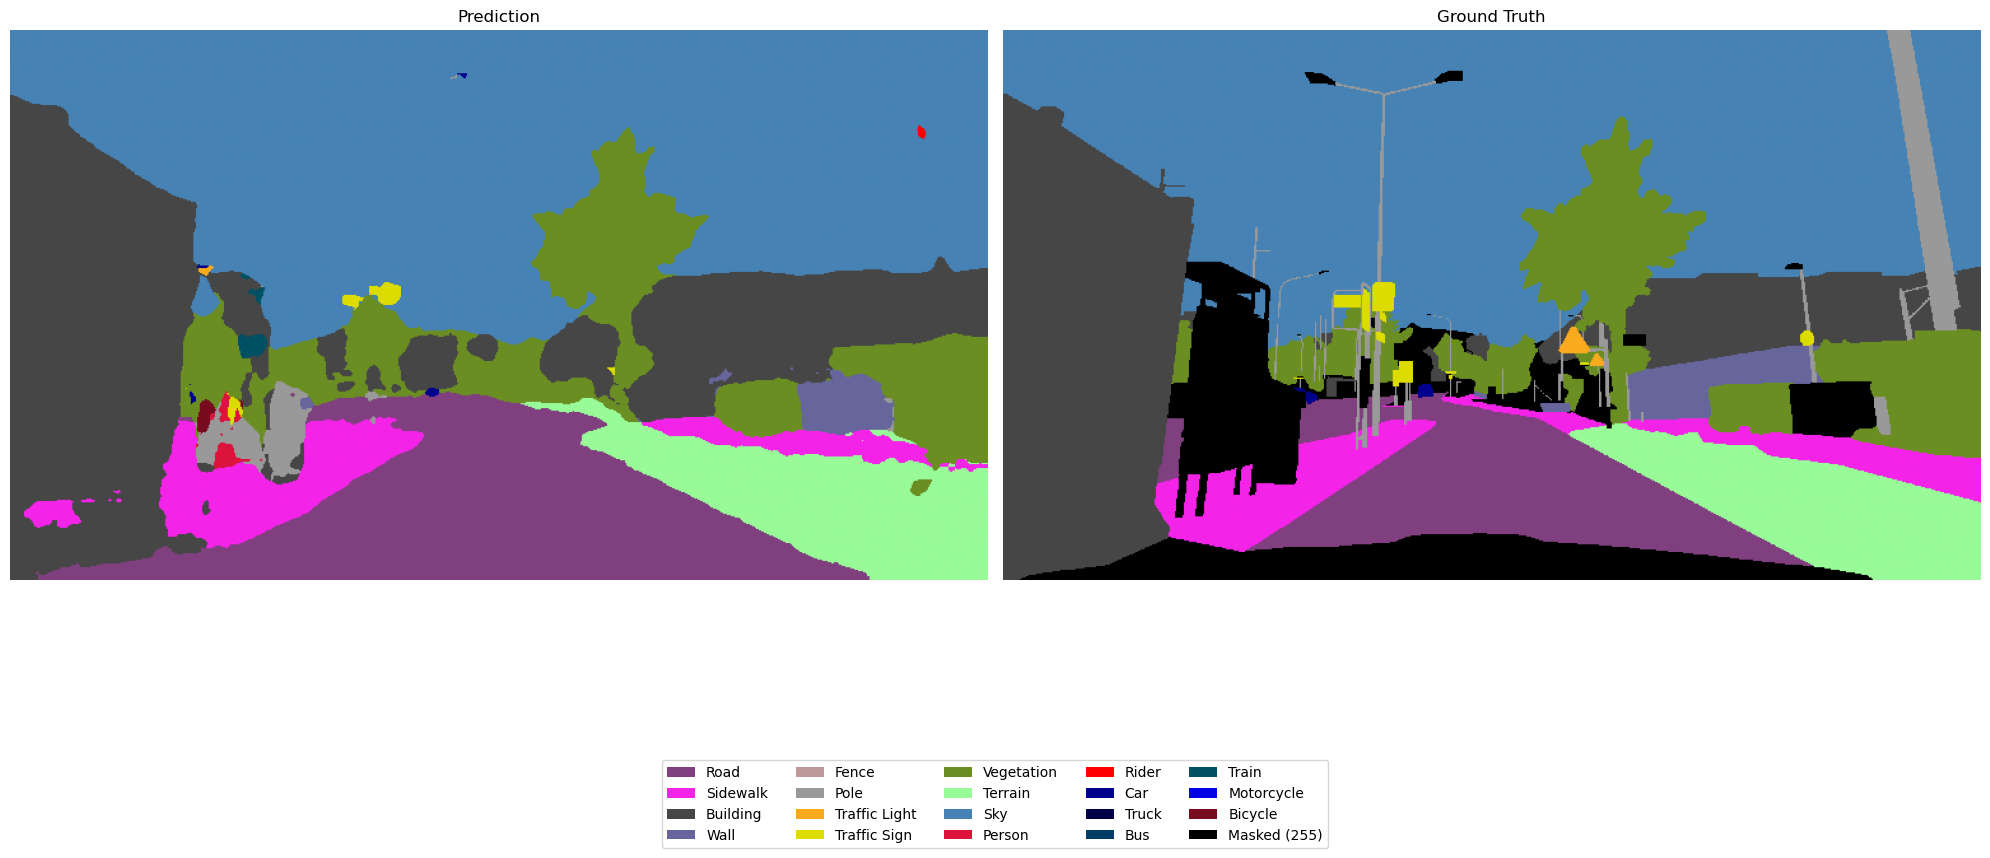

Total pixels: 331776
Masked pixels: 36228
Comparable pixels: 295548
Correct pixels: 267572
Incorrect pixels: 27976
Accuracy: 90.53%


In [36]:
plot_preds(model,val_dataloaders[2])

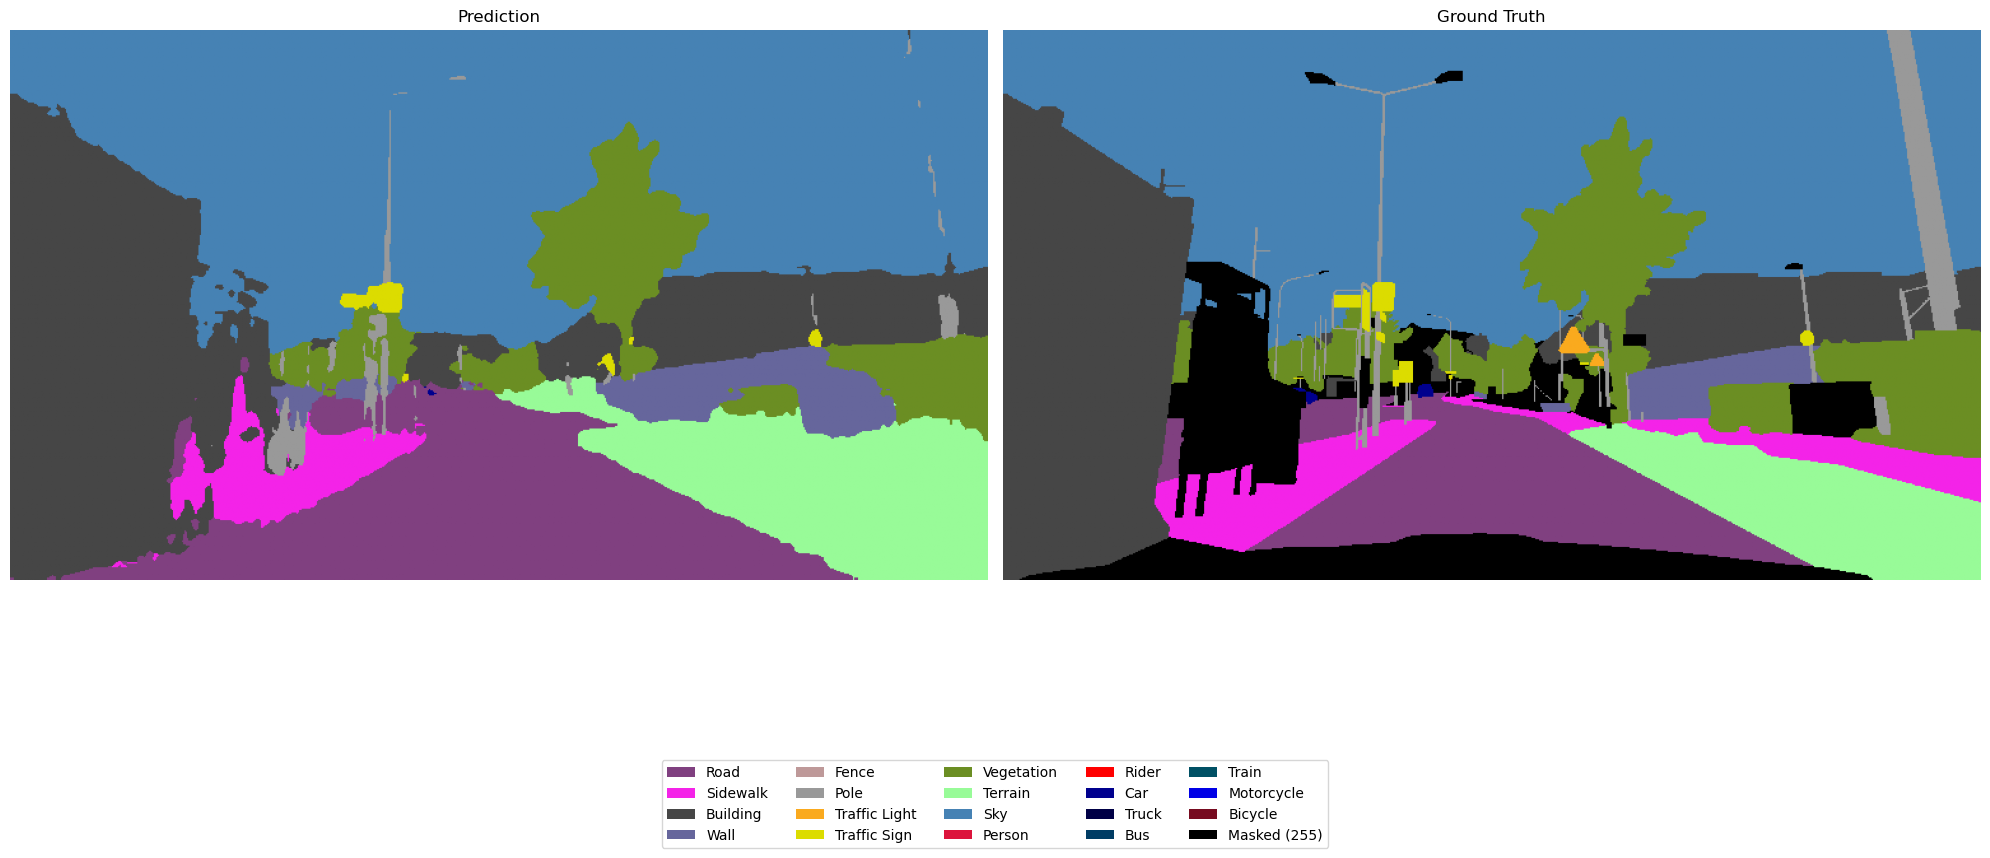

Total pixels: 331776
Masked pixels: 36228
Comparable pixels: 295548
Correct pixels: 267782
Incorrect pixels: 27766
Accuracy: 90.61%


In [39]:
plot_preds(model,val_dataloaders[2])

In [9]:
pretrained_weights = torch.load('/BS/DApt/work/project/segformer_test/work_dirs/fog_oraclev10_8x8_2.5/best_mIoU_iter_18500.pth')
#xxx = torch.load('/BS/DApt/work/project/segformer_test/work_dirs/b5_night_IDASS_inc_v2/teacher.pth')

new_dict = {}
for n,px in pretrained_weights['state_dict'].items():
    #print(n)
    parts = n.split('.')
    if 'teacher_backb' in n:
        new_n = 'backbone' + '.' + '.'.join(parts[1:])
        new_dict[new_n] = px

    if 'teacher_dec' in n:
        new_n = 'decode_head' + '.' + '.'.join(parts[1:])
        new_dict[new_n] = px
        

torch.save(new_dict, '/BS/DApt/work/project/segformer_test/work_dirs/fog_oraclev10_8x8_2.5/teacher.pth')